In [1]:
# import system libs
import os
from glob import glob

from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from UNet0 import UNet
# import albumentations as A
# from albumentations.pytorch import ToTensorV2
# import cv2
# import pandas as pd
# import numpy as np
from utils import  create_dataloader, dice_loss, dice_coef, iou_coef
from torch.utils.tensorboard import SummaryWriter
# import data handling tools
import cv2
import numpy as np
import pandas as pd
# import seaborn as sns
# %matplotlib inline
# from skimage.color import rgb2gray
# from skimage.morphology import label
# from skimage.transform import resize
# from skimage.io import imread, imshow, concatenate_images
# sns.set_style('darkgrid')

%reload_ext autoreload
%autoreload 2

In [2]:
def create_df(data_dir):
    images_paths = []
    masks_paths = sorted(glob(f'{data_dir}/*/*_mask*'))

    for i in masks_paths:
        images_paths.append(i.replace('_mask', ''))

    df = pd.DataFrame(data= {'images_paths': images_paths, 'masks_paths': masks_paths})

    return df

# Function to split dataframe into train, valid, test
def split_df(df):
    # create train_df
    train_df, dummy_df = train_test_split(df, train_size= 0.8)

    # create valid_df and test_df
    valid_df, test_df = train_test_split(dummy_df, train_size= 0.5)

    return train_df, valid_df, test_df

In [3]:
data_dir = '/workspaces/data/kaggle_3m'

df = create_df(data_dir)
train_df, valid_df, test_df = split_df(df)

In [4]:
len(train_df), len(valid_df), len(test_df)

(3143, 393, 393)

In [5]:
# %load_ext autoreload
# %autoreload 2
#from utils import create_dataloader
BATCH_SIZE = 8
train_loader = create_dataloader(train_df, batch_size=BATCH_SIZE, augment=True)
valid_loader = create_dataloader(valid_df, batch_size=BATCH_SIZE, augment=False)
test_loader = create_dataloader(test_df, batch_size=BATCH_SIZE, augment=False)


/home/vscode/.local/lib/python3.10/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


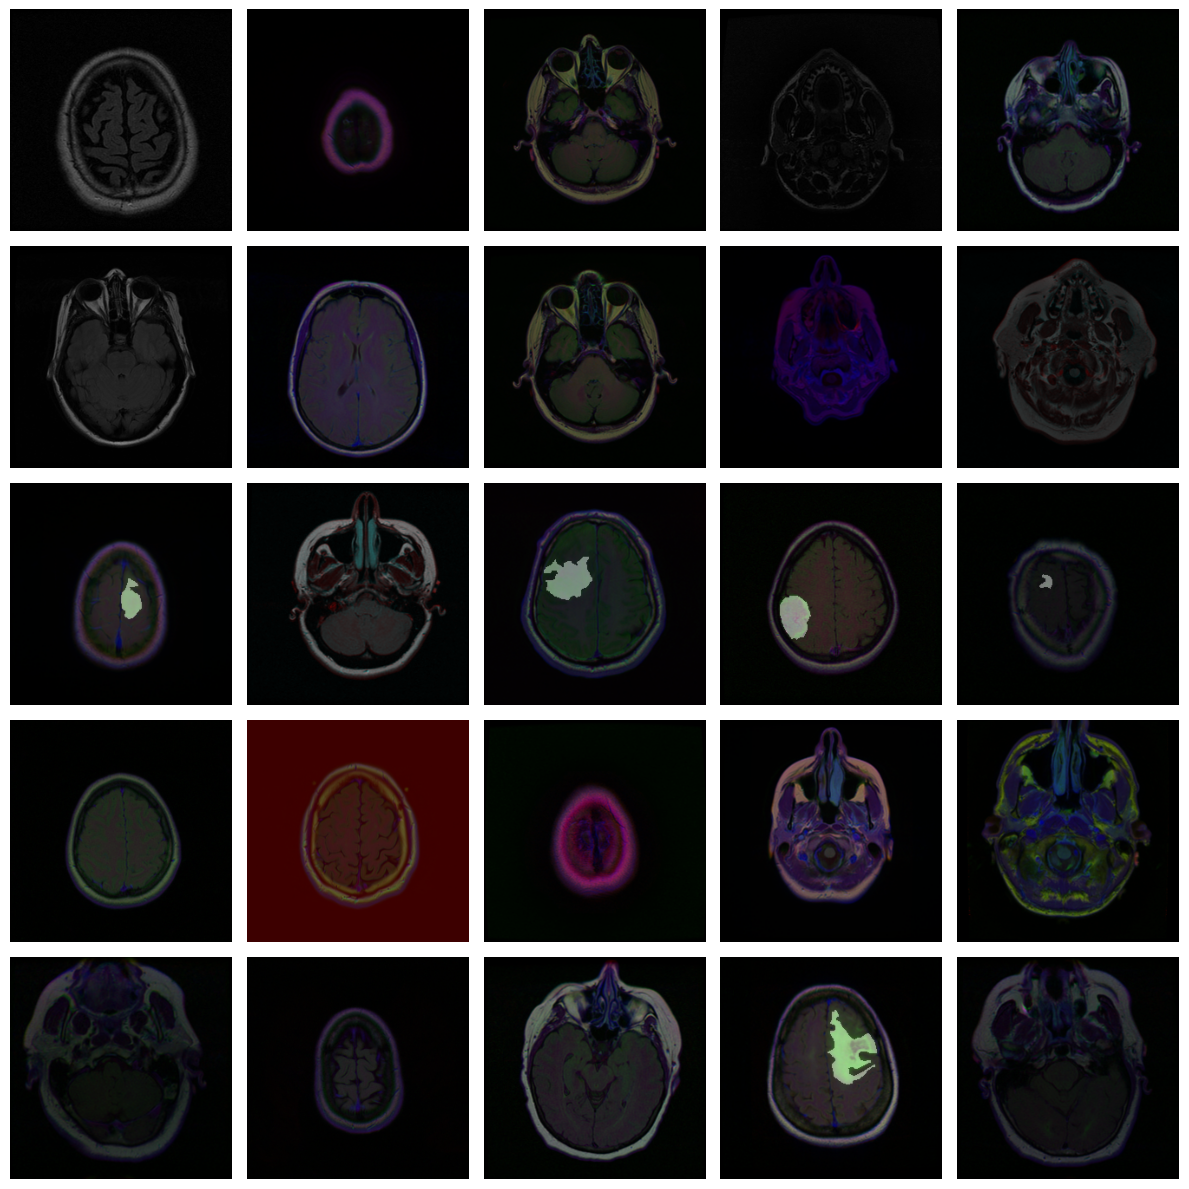

In [6]:
from utils import show_images
show_images(list(train_df['images_paths']), list(train_df['masks_paths']))

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = UNet(in_channels=3, out_channels=1).to(device)
optimizer = optim.Adamax(model.parameters(), lr=0.001)
criterion = dice_loss  # al

def train_one_epoch(model, dataloader, optimizer, criterion):
    model.train()
    total_loss = 0
    total_dice = 0
    total_iou = 0

    for images, masks in tqdm(dataloader, desc='Training'):
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)#round2: should be sigmoid activation
        # outputs = torch.sigmoid(outputs)  ## Not needed
        loss = criterion(masks, outputs)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_dice += dice_coef(masks, outputs).item()
        total_iou += iou_coef(masks, outputs).item()

    n = len(dataloader)
    return total_loss / n, total_dice / n, total_iou / n



def validate(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    total_dice = 0
    total_iou = 0

    with torch.no_grad():
        for images, masks in tqdm(dataloader, desc='Validating'):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)

            loss = criterion(masks, outputs)
            total_loss += loss.item()
            total_dice += dice_coef(masks, outputs).item()
            total_iou += iou_coef(masks, outputs).item()

    n = len(dataloader)
    return total_loss / n, total_dice / n, total_iou / n


In [8]:
from torchinfo import summary
summary(model, input_size=(BATCH_SIZE, 3, 256, 256))

Layer (type:depth-idx)                   Output Shape              Param #
UNet                                     [8, 1, 256, 256]          --
├─ConvBlock: 1-1                         [8, 64, 256, 256]         --
│    └─Sequential: 2-1                   [8, 64, 256, 256]         --
│    │    └─Conv2d: 3-1                  [8, 64, 256, 256]         1,792
│    │    └─ReLU: 3-2                    [8, 64, 256, 256]         --
│    │    └─Conv2d: 3-3                  [8, 64, 256, 256]         36,928
│    │    └─BatchNorm2d: 3-4             [8, 64, 256, 256]         128
│    │    └─ReLU: 3-5                    [8, 64, 256, 256]         --
├─MaxPool2d: 1-2                         [8, 64, 128, 128]         --
├─ConvBlock: 1-3                         [8, 128, 128, 128]        --
│    └─Sequential: 2-2                   [8, 128, 128, 128]        --
│    │    └─Conv2d: 3-6                  [8, 128, 128, 128]        73,856
│    │    └─ReLU: 3-7                    [8, 128, 128, 128]        --
│  

In [9]:
# import os
import datetime

epochs = 120
best_val_loss = float('inf')
save_path = 'unet.pth'

log_dir = os.path.join("/workspaces/data/MegaGen/UNet", 
                       "unet_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
writer = SummaryWriter(log_dir=log_dir)
history = {
    'train_loss': [],
    'train_dice': [],
    'train_iou': [],
    'val_loss': [],
    'val_dice': [],
    'val_iou': [],
}



In [ ]:
print ("device:",next(model.parameters()).device)
for epoch in range(1, epochs + 1):
    print(f"\nEpoch {epoch}/{epochs}")

    train_loss, train_dice, train_iou = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_dice, val_iou = validate(model, valid_loader, criterion)

    print(f"Train Loss: {train_loss:.4f}, Dice: {train_dice:.4f}, IoU: {train_iou:.4f}")
    print(f"Val   Loss: {val_loss:.4f}, Dice: {val_dice:.4f}, IoU: {val_iou:.4f}")

    # Save best model
    if val_loss < best_val_loss:
        print(f"Validation loss improved ({best_val_loss:.4f} → {val_loss:.4f}). Saving model...")
        best_val_loss = val_loss
        torch.save(model.state_dict(), save_path)

    # Log to TensorBoard
    writer.add_scalar("Loss/Train", train_loss, epoch)
    writer.add_scalar("Loss/Val", val_loss, epoch)
    writer.add_scalar("Dice/Train", train_dice, epoch)
    writer.add_scalar("Dice/Val", val_dice, epoch)
    writer.add_scalar("IoU/Train", train_iou, epoch)
    writer.add_scalar("IoU/Val", val_iou, epoch)

    # Save to history
    history['train_loss'].append(train_loss)
    history['train_dice'].append(train_dice)
    history['train_iou'].append(train_iou)
    history['val_loss'].append(val_loss)
    history['val_dice'].append(val_dice)
    history['val_iou'].append(val_iou)


device: cuda:0

Epoch 1/120


Validating: 100%|██████████| 50/50 [00:05<00:00,  8.37it/s]


Train Loss: -0.1324, Dice: 0.1324, IoU: 0.0771
Val   Loss: -0.2632, Dice: 0.2632, IoU: 0.1672
Validation loss improved (inf → -0.2632). Saving model...

Epoch 2/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.19it/s]


Train Loss: -0.4939, Dice: 0.4939, IoU: 0.3618
Val   Loss: -0.6341, Dice: 0.6341, IoU: 0.4960
Validation loss improved (-0.2632 → -0.6341). Saving model...

Epoch 3/120


Validating: 100%|██████████| 50/50 [00:05<00:00,  9.01it/s]


Train Loss: -0.5822, Dice: 0.5822, IoU: 0.4521
Val   Loss: -0.6570, Dice: 0.6570, IoU: 0.5364
Validation loss improved (-0.6341 → -0.6570). Saving model...

Epoch 4/120


Validating: 100%|██████████| 50/50 [00:05<00:00,  9.05it/s]


Train Loss: -0.6187, Dice: 0.6187, IoU: 0.4920
Val   Loss: -0.5688, Dice: 0.5688, IoU: 0.4446

Epoch 5/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.25it/s]


Train Loss: -0.6458, Dice: 0.6458, IoU: 0.5186
Val   Loss: -0.6942, Dice: 0.6942, IoU: 0.5803
Validation loss improved (-0.6570 → -0.6942). Saving model...

Epoch 6/120


Validating: 100%|██████████| 50/50 [00:05<00:00,  8.96it/s]


Train Loss: -0.6515, Dice: 0.6515, IoU: 0.5285
Val   Loss: -0.6913, Dice: 0.6913, IoU: 0.5808

Epoch 7/120


Validating: 100%|██████████| 50/50 [00:05<00:00,  9.01it/s]


Train Loss: -0.6357, Dice: 0.6357, IoU: 0.5126
Val   Loss: -0.6893, Dice: 0.6893, IoU: 0.5772

Epoch 8/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.22it/s]


Train Loss: -0.6615, Dice: 0.6615, IoU: 0.5405
Val   Loss: -0.7340, Dice: 0.7340, IoU: 0.6214
Validation loss improved (-0.6942 → -0.7340). Saving model...

Epoch 9/120


Validating: 100%|██████████| 50/50 [00:05<00:00,  8.89it/s]


Train Loss: -0.6557, Dice: 0.6557, IoU: 0.5337
Val   Loss: -0.6490, Dice: 0.6490, IoU: 0.5343

Epoch 10/120


Validating: 100%|██████████| 50/50 [00:05<00:00,  8.85it/s]


Train Loss: -0.6520, Dice: 0.6520, IoU: 0.5300
Val   Loss: -0.6183, Dice: 0.6183, IoU: 0.5058

Epoch 11/120


Validating: 100%|██████████| 50/50 [00:05<00:00,  8.94it/s]


Train Loss: -0.6503, Dice: 0.6503, IoU: 0.5321
Val   Loss: -0.7544, Dice: 0.7544, IoU: 0.6403
Validation loss improved (-0.7340 → -0.7544). Saving model...

Epoch 12/120


Validating: 100%|██████████| 50/50 [00:05<00:00,  9.01it/s]


Train Loss: -0.6856, Dice: 0.6856, IoU: 0.5645
Val   Loss: -0.6949, Dice: 0.6949, IoU: 0.5865

Epoch 13/120


Validating: 100%|██████████| 50/50 [00:05<00:00,  9.00it/s]


Train Loss: -0.6835, Dice: 0.6835, IoU: 0.5620
Val   Loss: -0.7578, Dice: 0.7578, IoU: 0.6487
Validation loss improved (-0.7544 → -0.7578). Saving model...

Epoch 14/120


Validating: 100%|██████████| 50/50 [00:05<00:00,  8.97it/s]


Train Loss: -0.6858, Dice: 0.6858, IoU: 0.5671
Val   Loss: -0.7217, Dice: 0.7217, IoU: 0.6076

Epoch 15/120


Validating: 100%|██████████| 50/50 [00:05<00:00,  9.04it/s]


Train Loss: -0.6908, Dice: 0.6908, IoU: 0.5724
Val   Loss: -0.7445, Dice: 0.7445, IoU: 0.6185

Epoch 16/120


Validating: 100%|██████████| 50/50 [00:05<00:00,  8.99it/s]


Train Loss: -0.6778, Dice: 0.6778, IoU: 0.5592
Val   Loss: -0.7205, Dice: 0.7205, IoU: 0.6107

Epoch 17/120


Validating: 100%|██████████| 50/50 [00:05<00:00,  9.05it/s]


Train Loss: -0.6846, Dice: 0.6846, IoU: 0.5680
Val   Loss: -0.7394, Dice: 0.7394, IoU: 0.6294

Epoch 18/120


Validating: 100%|██████████| 50/50 [00:05<00:00,  9.03it/s]


Train Loss: -0.6808, Dice: 0.6808, IoU: 0.5608
Val   Loss: -0.7486, Dice: 0.7486, IoU: 0.6427

Epoch 19/120


Validating: 100%|██████████| 50/50 [00:05<00:00,  9.05it/s]


Train Loss: -0.6977, Dice: 0.6977, IoU: 0.5802
Val   Loss: -0.7539, Dice: 0.7539, IoU: 0.6383

Epoch 20/120


Validating: 100%|██████████| 50/50 [00:05<00:00,  9.01it/s]


Train Loss: -0.6981, Dice: 0.6981, IoU: 0.5817
Val   Loss: -0.7248, Dice: 0.7248, IoU: 0.6117

Epoch 21/120


Validating: 100%|██████████| 50/50 [00:05<00:00,  9.03it/s]


Train Loss: -0.7035, Dice: 0.7035, IoU: 0.5865
Val   Loss: -0.7679, Dice: 0.7679, IoU: 0.6530
Validation loss improved (-0.7578 → -0.7679). Saving model...

Epoch 22/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.47it/s]


Train Loss: -0.6941, Dice: 0.6941, IoU: 0.5787
Val   Loss: -0.7922, Dice: 0.7922, IoU: 0.6879
Validation loss improved (-0.7679 → -0.7922). Saving model...

Epoch 23/120


Validating: 100%|██████████| 50/50 [00:05<00:00,  9.00it/s]


Train Loss: -0.7197, Dice: 0.7197, IoU: 0.6072
Val   Loss: -0.7716, Dice: 0.7716, IoU: 0.6778

Epoch 24/120


Validating: 100%|██████████| 50/50 [00:05<00:00,  9.03it/s]


Train Loss: -0.7243, Dice: 0.7243, IoU: 0.6079
Val   Loss: -0.7891, Dice: 0.7891, IoU: 0.6851

Epoch 25/120


Validating: 100%|██████████| 50/50 [00:07<00:00,  6.94it/s]


Train Loss: -0.7020, Dice: 0.7020, IoU: 0.5883
Val   Loss: -0.8088, Dice: 0.8088, IoU: 0.7044
Validation loss improved (-0.7922 → -0.8088). Saving model...

Epoch 26/120


Validating: 100%|██████████| 50/50 [00:05<00:00,  8.90it/s]


Train Loss: -0.7026, Dice: 0.7026, IoU: 0.5870
Val   Loss: -0.7357, Dice: 0.7357, IoU: 0.6166

Epoch 27/120


Validating: 100%|██████████| 50/50 [00:05<00:00,  8.90it/s]


Train Loss: -0.7236, Dice: 0.7236, IoU: 0.6076
Val   Loss: -0.7771, Dice: 0.7771, IoU: 0.6706

Epoch 28/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.49it/s]


Train Loss: -0.7388, Dice: 0.7388, IoU: 0.6240
Val   Loss: -0.7854, Dice: 0.7854, IoU: 0.6775

Epoch 29/120


Validating: 100%|██████████| 50/50 [00:05<00:00,  8.89it/s]


Train Loss: -0.6986, Dice: 0.6986, IoU: 0.5847
Val   Loss: -0.6935, Dice: 0.6935, IoU: 0.5934

Epoch 30/120


Validating: 100%|██████████| 50/50 [00:05<00:00,  9.01it/s]


Train Loss: -0.7117, Dice: 0.7117, IoU: 0.5972
Val   Loss: -0.7289, Dice: 0.7289, IoU: 0.6222

Epoch 31/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.44it/s]


Train Loss: -0.7441, Dice: 0.7441, IoU: 0.6314
Val   Loss: -0.7616, Dice: 0.7616, IoU: 0.6556

Epoch 32/120


Validating: 100%|██████████| 50/50 [00:05<00:00,  8.97it/s]


Train Loss: -0.7435, Dice: 0.7435, IoU: 0.6335
Val   Loss: -0.8067, Dice: 0.8067, IoU: 0.6994

Epoch 33/120


Validating: 100%|██████████| 50/50 [00:05<00:00,  8.94it/s]


Train Loss: -0.7265, Dice: 0.7265, IoU: 0.6167
Val   Loss: -0.7884, Dice: 0.7884, IoU: 0.6906

Epoch 34/120


Validating: 100%|██████████| 50/50 [00:05<00:00,  8.95it/s]


Train Loss: -0.7176, Dice: 0.7176, IoU: 0.6074
Val   Loss: -0.7438, Dice: 0.7438, IoU: 0.6380

Epoch 35/120


Validating: 100%|██████████| 50/50 [00:05<00:00,  8.92it/s]


Train Loss: -0.7252, Dice: 0.7252, IoU: 0.6144
Val   Loss: -0.7924, Dice: 0.7924, IoU: 0.6942

Epoch 36/120


Validating: 100%|██████████| 50/50 [00:05<00:00,  8.94it/s]


Train Loss: -0.7358, Dice: 0.7358, IoU: 0.6266
Val   Loss: -0.7966, Dice: 0.7966, IoU: 0.6941

Epoch 37/120


Validating: 100%|██████████| 50/50 [00:05<00:00,  8.78it/s]


Train Loss: -0.7291, Dice: 0.7291, IoU: 0.6194
Val   Loss: -0.8072, Dice: 0.8072, IoU: 0.7037

Epoch 38/120


Validating: 100%|██████████| 50/50 [00:05<00:00,  8.90it/s]


Train Loss: -0.7557, Dice: 0.7557, IoU: 0.6488
Val   Loss: -0.7543, Dice: 0.7543, IoU: 0.6482

Epoch 39/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.32it/s]


Train Loss: -0.7306, Dice: 0.7306, IoU: 0.6228
Val   Loss: -0.7686, Dice: 0.7686, IoU: 0.6669

Epoch 40/120


Validating: 100%|██████████| 50/50 [00:05<00:00,  8.87it/s]


Train Loss: -0.7147, Dice: 0.7147, IoU: 0.6042
Val   Loss: -0.7802, Dice: 0.7802, IoU: 0.6771

Epoch 41/120


Validating: 100%|██████████| 50/50 [00:05<00:00,  8.89it/s]


Train Loss: -0.7420, Dice: 0.7420, IoU: 0.6335
Val   Loss: -0.7992, Dice: 0.7992, IoU: 0.7009

Epoch 42/120


Validating: 100%|██████████| 50/50 [00:05<00:00,  8.88it/s]


Train Loss: -0.7091, Dice: 0.7091, IoU: 0.6017
Val   Loss: -0.7296, Dice: 0.7296, IoU: 0.6174

Epoch 43/120


Validating: 100%|██████████| 50/50 [00:05<00:00,  8.93it/s]


Train Loss: -0.7228, Dice: 0.7228, IoU: 0.6140
Val   Loss: -0.8279, Dice: 0.8279, IoU: 0.7303
Validation loss improved (-0.8088 → -0.8279). Saving model...

Epoch 44/120


Validating: 100%|██████████| 50/50 [00:05<00:00,  8.95it/s]


Train Loss: -0.7527, Dice: 0.7527, IoU: 0.6405
Val   Loss: -0.8201, Dice: 0.8201, IoU: 0.7209

Epoch 45/120


Validating: 100%|██████████| 50/50 [00:05<00:00,  8.92it/s]


Train Loss: -0.7536, Dice: 0.7536, IoU: 0.6439
Val   Loss: -0.7851, Dice: 0.7851, IoU: 0.6924

Epoch 46/120


Validating: 100%|██████████| 50/50 [00:05<00:00,  8.90it/s]


Train Loss: -0.7517, Dice: 0.7517, IoU: 0.6460
Val   Loss: -0.8264, Dice: 0.8264, IoU: 0.7261

Epoch 47/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.50it/s]


Train Loss: -0.7499, Dice: 0.7499, IoU: 0.6413
Val   Loss: -0.8207, Dice: 0.8207, IoU: 0.7152

Epoch 48/120


Validating: 100%|██████████| 50/50 [00:05<00:00,  8.78it/s]


Train Loss: -0.7372, Dice: 0.7372, IoU: 0.6289
Val   Loss: -0.8084, Dice: 0.8084, IoU: 0.7070

Epoch 49/120


Validating: 100%|██████████| 50/50 [00:05<00:00,  8.89it/s]


Train Loss: -0.7329, Dice: 0.7329, IoU: 0.6250
Val   Loss: -0.7908, Dice: 0.7908, IoU: 0.6911

Epoch 50/120


Validating: 100%|██████████| 50/50 [00:05<00:00,  8.69it/s]


Train Loss: -0.7471, Dice: 0.7471, IoU: 0.6403
Val   Loss: -0.8231, Dice: 0.8231, IoU: 0.7260

Epoch 51/120


Validating: 100%|██████████| 50/50 [00:05<00:00,  8.89it/s]


Train Loss: -0.7611, Dice: 0.7611, IoU: 0.6541
Val   Loss: -0.7712, Dice: 0.7712, IoU: 0.6714

Epoch 52/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.69it/s]


Train Loss: -0.7638, Dice: 0.7638, IoU: 0.6578
Val   Loss: -0.7926, Dice: 0.7926, IoU: 0.6870

Epoch 53/120


Validating: 100%|██████████| 50/50 [00:05<00:00,  8.86it/s]


Train Loss: -0.7438, Dice: 0.7438, IoU: 0.6374
Val   Loss: -0.7634, Dice: 0.7634, IoU: 0.6713

Epoch 54/120


Validating: 100%|██████████| 50/50 [00:05<00:00,  8.89it/s]


Train Loss: -0.7434, Dice: 0.7434, IoU: 0.6386
Val   Loss: -0.8063, Dice: 0.8063, IoU: 0.7145

Epoch 55/120


Validating: 100%|██████████| 50/50 [00:05<00:00,  8.60it/s]


Train Loss: -0.7663, Dice: 0.7663, IoU: 0.6634
Val   Loss: -0.8003, Dice: 0.8003, IoU: 0.7145

Epoch 56/120


Validating: 100%|██████████| 50/50 [00:05<00:00,  8.66it/s]


Train Loss: -0.7792, Dice: 0.7792, IoU: 0.6738
Val   Loss: -0.8263, Dice: 0.8263, IoU: 0.7271

Epoch 57/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.95it/s]


Train Loss: -0.7602, Dice: 0.7602, IoU: 0.6566
Val   Loss: -0.7606, Dice: 0.7606, IoU: 0.6539

Epoch 58/120


Validating: 100%|██████████| 50/50 [00:05<00:00,  8.87it/s]


Train Loss: -0.7557, Dice: 0.7557, IoU: 0.6496
Val   Loss: -0.8190, Dice: 0.8190, IoU: 0.7217

Epoch 59/120


Validating: 100%|██████████| 50/50 [00:05<00:00,  8.82it/s]


Train Loss: -0.7608, Dice: 0.7608, IoU: 0.6564
Val   Loss: -0.8045, Dice: 0.8045, IoU: 0.7101

Epoch 60/120


Validating: 100%|██████████| 50/50 [00:05<00:00,  8.63it/s]


Train Loss: -0.7583, Dice: 0.7583, IoU: 0.6524
Val   Loss: -0.7967, Dice: 0.7967, IoU: 0.6989

Epoch 61/120


Validating: 100%|██████████| 50/50 [00:05<00:00,  8.86it/s]


Train Loss: -0.7794, Dice: 0.7794, IoU: 0.6739
Val   Loss: -0.8430, Dice: 0.8430, IoU: 0.7442
Validation loss improved (-0.8279 → -0.8430). Saving model...

Epoch 62/120


Validating: 100%|██████████| 50/50 [00:05<00:00,  8.66it/s]


Train Loss: -0.7719, Dice: 0.7719, IoU: 0.6689
Val   Loss: -0.7868, Dice: 0.7868, IoU: 0.6938

Epoch 63/120


Validating: 100%|██████████| 50/50 [00:05<00:00,  8.74it/s]


Train Loss: -0.7585, Dice: 0.7585, IoU: 0.6567
Val   Loss: -0.8096, Dice: 0.8096, IoU: 0.7102

Epoch 64/120


Validating: 100%|██████████| 50/50 [00:05<00:00,  8.39it/s]


Train Loss: -0.7773, Dice: 0.7773, IoU: 0.6759
Val   Loss: -0.8419, Dice: 0.8419, IoU: 0.7533

Epoch 65/120


Validating: 100%|██████████| 50/50 [00:05<00:00,  8.72it/s]


Train Loss: -0.7715, Dice: 0.7715, IoU: 0.6654
Val   Loss: -0.8377, Dice: 0.8377, IoU: 0.7383

Epoch 66/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.84it/s]


Train Loss: -0.7672, Dice: 0.7672, IoU: 0.6651
Val   Loss: -0.7179, Dice: 0.7179, IoU: 0.6241

Epoch 67/120


Validating: 100%|██████████| 50/50 [00:05<00:00,  8.77it/s]


Train Loss: -0.7724, Dice: 0.7724, IoU: 0.6706
Val   Loss: -0.8124, Dice: 0.8124, IoU: 0.7078

Epoch 68/120


Validating: 100%|██████████| 50/50 [00:05<00:00,  8.37it/s]


Train Loss: -0.7723, Dice: 0.7723, IoU: 0.6730
Val   Loss: -0.8113, Dice: 0.8113, IoU: 0.7103

Epoch 69/120


Validating: 100%|██████████| 50/50 [00:05<00:00,  8.82it/s]


Train Loss: -0.7845, Dice: 0.7845, IoU: 0.6850
Val   Loss: -0.7761, Dice: 0.7761, IoU: 0.6936

Epoch 70/120


Validating: 100%|██████████| 50/50 [00:05<00:00,  8.81it/s]


Train Loss: -0.7747, Dice: 0.7747, IoU: 0.6733
Val   Loss: -0.8007, Dice: 0.8007, IoU: 0.7019

Epoch 71/120


Validating: 100%|██████████| 50/50 [00:05<00:00,  8.73it/s]


Train Loss: -0.7783, Dice: 0.7783, IoU: 0.6784
Val   Loss: -0.8143, Dice: 0.8143, IoU: 0.7178

Epoch 72/120


Validating: 100%|██████████| 50/50 [00:05<00:00,  8.77it/s]


Train Loss: -0.7928, Dice: 0.7928, IoU: 0.6937
Val   Loss: -0.8200, Dice: 0.8200, IoU: 0.7283

Epoch 73/120


Validating: 100%|██████████| 50/50 [00:05<00:00,  8.53it/s]


Train Loss: -0.7686, Dice: 0.7686, IoU: 0.6638
Val   Loss: -0.8349, Dice: 0.8349, IoU: 0.7493

Epoch 74/120


Validating: 100%|██████████| 50/50 [00:05<00:00,  8.80it/s]


Train Loss: -0.7737, Dice: 0.7737, IoU: 0.6711
Val   Loss: -0.8443, Dice: 0.8443, IoU: 0.7534
Validation loss improved (-0.8430 → -0.8443). Saving model...

Epoch 75/120


Validating: 100%|██████████| 50/50 [00:05<00:00,  8.67it/s]


Train Loss: -0.7838, Dice: 0.7838, IoU: 0.6837
Val   Loss: -0.8287, Dice: 0.8287, IoU: 0.7442

Epoch 76/120


Validating: 100%|██████████| 50/50 [00:05<00:00,  8.80it/s]


Train Loss: -0.8187, Dice: 0.8187, IoU: 0.7237
Val   Loss: -0.8361, Dice: 0.8361, IoU: 0.7490

Epoch 77/120


Training:  72%|███████▏  | 281/393 [01:32<00:36,  3.03it/s]

In [11]:
cv2.imread(train_df.iloc[1].images_paths).shape

(256, 256, 3)